In [1]:
from cooltools import snipping
import cooler
import pandas as pd
import numpy as np
import pybedtools
import bioframe
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os


/pollard/home/xiaofanj/miniconda3/envs/hic/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams.update({'font.size': 24})
chromsizes=bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

binsDf=pd.read_csv('../data/genomeInfo/mm10bin5kb.bed',sep='\t',header=None,names=['chrom','start','end']) #bin file can be made with cooler makebins, binsize = 5000

signalFiles=glob.glob('../data/binnedBedgraphs/*')
signalDf=binsDf.copy()
for signalFile in signalFiles:
    signalDf=signalDf.merge(pd.read_csv(signalFile,sep="\t", header=None,names=['chrom','start','end',os.path.basename(signalFile).split('.')[0]]),how='left',on=['chrom','start','end'])
    signalDf.drop_duplicates(subset=['chrom','start','end'],inplace=True)

In [3]:
def splitQuantile(toSplit,splitOn,quantiles=4):
    quantileLims=np.linspace(0,len(toSplit),quantiles+1).astype(int)
    sortedArray=splitOn[toSplit].sort_values().index.to_numpy()
    quantiles=[sortedArray[quantileLims[ind]:quantileLims[ind+1]] for ind in range(quantiles)]
    return quantiles

def getPeakInds(peakFile,binsize=5000,flank=300000,supports=supports):
    peakDf=pd.read_csv(peakFile,header=None,sep="\t",names=['chrom','start','end','name','score','strand','signalValue','pvalue','qvalue','peak'])
    windows = snipping.make_bin_aligned_windows(
        binsize,
        peakDf['chrom'],
        (peakDf['start'] + peakDf['end'])//2,
        flank_bp=flank)
    windows=windows.merge(pd.DataFrame(supports,columns=['chrom','zero','chromsize']),how='left',on='chrom')
    windows=windows[(windows.end<windows.chromsize) & (windows.start>0)].drop_duplicates()
    windows=windows.loc[(windows.chrom!='chrX')&(windows.chrom!='chrY')&(windows.chrom!='chrM'),:]
    startInds=binsDf.reset_index().merge(windows[['chrom','start']],how='inner',on=['chrom','start'])['index']
    endInds=binsDf.reset_index().merge(windows[['chrom','end']],how='inner',on=['chrom','end'])['index']
    indDf=pd.DataFrame({'startInd':startInds,'endInd':endInds})
    return ((indDf.startInd+indDf.endInd)//2).values

def makeTracePlots(posListDict, signalLabelsDf, rowOrder=None,colOrder=None,palette=None, numBins=121, saveName=None, df=signalDf, avgType='median', xlabel='Relative position (kb)',aspectRatio=1.5, plotHeight=2.7,shareColAxes='stretch'):
    if rowOrder is None:
        rowOrder=signalLabelsDf.row.unique()
    if colOrder is None:
        colOrder=signalLabelsDf.col.unique()
    if len(rowOrder)==1:
        plotHeight=plotHeight*1.25
        aspectRatio=aspectRatio*0.8
    halfBins=int((numBins-1)/2)
    windowAverageDf=pd.DataFrame([])
    genomeAverages=np.zeros(len(signalLabelsDf.index))
    for varInd in signalLabelsDf.index:
        var=signalLabelsDf.loc[varInd,'var']
        colLabel=signalLabelsDf.loc[varInd,'col']
        rowLabel=signalLabelsDf.loc[varInd,'row']
        if avgType=='mean':
            genomeAverages[varInd]=df[var].mean()
        elif avgType=='median':
            genomeAverages[varInd]=df[var].median()
        for posListInd,posListKey in enumerate(posListDict):
            posList=posListDict[posListKey]
            windowAverages=np.zeros((numBins,len(posList)))
            for posInd,pos in enumerate(posList):
                windowAverages[:,posInd]=df[var][pos-halfBins:pos+halfBins+1]
            windowDf=pd.DataFrame(windowAverages.T).stack().reset_index()
            windowDf.rename(columns={0: "Score"}, inplace=True)
            windowDf[xlabel]=5*(windowDf.level_1-halfBins)
            windowDf['ChIP-seq peaks']=posListKey
            windowDf['col']=colLabel
            windowDf['row']=rowLabel
            windowAverageDf=windowAverageDf.append(windowDf)
    signalLabelsDf['genomeAverages']=genomeAverages
    sharey="col"
    g=sns.relplot(x=xlabel,y="Score",data=windowAverageDf, col="col", row='row',hue="ChIP-seq peaks", 
                  row_order=rowOrder,col_order=colOrder,
                  ci=95, kind="line", palette=palette, height=plotHeight, aspect=aspectRatio, 
                  facet_kws={'sharex':False,'sharey':"row" if shareColAxes=='yes' else False,'margin_titles':True})
    yMaxSubAvg=np.zeros((len(rowOrder),len(colOrder)))
    yMinSubAvg=np.zeros((len(rowOrder),len(colOrder)))
    for rowInd,row in enumerate(rowOrder):
        for colInd,col in enumerate(colOrder):
            genomeAverage=signalLabelsDf.loc[(signalLabelsDf.row==row)&(signalLabelsDf.col==col),'genomeAverages'].values[0]
            g.facet_axis(rowInd,colInd).axhline(y=genomeAverage, linestyle='--', color='grey', label='genome-wide '+avgType)
            yMaxSubAvg[rowInd,colInd]=g.facet_axis(rowInd,colInd).get_ylim()[1]-genomeAverage
            yMinSubAvg[rowInd,colInd]=g.facet_axis(rowInd,colInd).get_ylim()[0]-genomeAverage
    yMaxSubAvgLim=np.max(yMaxSubAvg, axis=1)
    yMinSubAvgLim=np.min(yMinSubAvg, axis=1)
    if shareColAxes=='stretch':
        for rowInd,row in enumerate(rowOrder):
            for colInd,col in enumerate(colOrder):
                genomeAverage=signalLabelsDf.loc[(signalLabelsDf.row==row)&(signalLabelsDf.col==col),'genomeAverages'].values[0]
                g.facet_axis(rowInd,colInd).set_ylim([genomeAverage+yMinSubAvgLim[rowInd],genomeAverage+yMaxSubAvgLim[rowInd]])

#     g.fig.tight_layout()

    plt.legend()
    if saveName is not None:
        plt.savefig(saveName)


In [4]:
peakFiles=glob.glob('../data/peakBeds/*')
peakIndsDict=dict(zip([os.path.basename(file).split('.')[0] for file in peakFiles],[getPeakInds(file) for file in peakFiles]))
saveDir='../outputs/'

In [5]:
greyPrdm9castSplitonDMC=splitQuantile(peakIndsDict['grey2017orig_PRDM9_RJ2_class1_peaks'],signalDf.smagulova2016_B6xCAST_DSB_fraglen1000)
greyPrdm9castPeakListDict={'Grey PRDM9-CAST sites (Class 1 - all)':peakIndsDict['grey2017orig_PRDM9_RJ2_class1_peaks'],
                   'Grey PRDM9-CAST sites (top-DSB)':greyPrdm9castSplitonDMC[-1],
                   'Grey PRDM9-CAST sites (bottom-DSB)':greyPrdm9castSplitonDMC[0]}
greyPrdm9castPeakListMetaDict={'dict':greyPrdm9castPeakListDict,'palette':[(0.75,0.5,0.75),(0.5,0.25,0.5),(1,0.75,1)],'save':'greyprdm9cast'}

greyPrdm9b6SplitonDMC=splitQuantile(peakIndsDict['grey2017orig_PRDM9_B6_class1_peaks'],signalDf.smagulova2016_B6xCAST_DSB_fraglen1000)
greyPrdm9b6PeakListDict={'Grey PRDM9-B6 sites (Class 1 - all)':peakIndsDict['grey2017orig_PRDM9_B6_class1_peaks'],
                   'Grey PRDM9-B6 sites (top-DSB)':greyPrdm9b6SplitonDMC[-1],
                   'Grey PRDM9-B6 sites (bottom-DSB)':greyPrdm9b6SplitonDMC[0]}
greyPrdm9b6PeakListMetaDict={'dict':greyPrdm9b6PeakListDict,'palette':[(0.75,0.5,0.75),(0.5,0.25,0.5),(1,0.75,1)],'save':'greyprdm9b6'}

greyPrdm9allPeakListDict={'Grey PRDM9-B6 sites (Class 1)':peakIndsDict['grey2017orig_PRDM9_B6_class1_peaks'],
                          'Grey PRDM9-B6 sites (Class 2)':peakIndsDict['grey2017orig_PRDM9_B6_class2_peaks'],
                          'Grey PRDM9-CAST sites (Class 1)':peakIndsDict['grey2017orig_PRDM9_RJ2_class1_peaks'],
                          'Grey PRDM9-CAST sites (Class 2)':peakIndsDict['grey2017orig_PRDM9_RJ2_class2_peaks']}
greyPrdm9allPeakListMetaDict={'dict':greyPrdm9allPeakListDict,'palette':None,'save':'greyprdm9all'}

prdm9SplitonDMC=splitQuantile(peakIndsDict['Baker2015_prdm9_B6xCAST_peaks'],signalDf.smagulova2016_B6xCAST_DSB_fraglen1000)
prdm9PeakListDict={'PRDM9 sites (all)':peakIndsDict['Baker2015_prdm9_B6xCAST_peaks'],
                   'PRDM9 sites (top-DSB)':prdm9SplitonDMC[-1],
                   'PRDM9 sites (bottom-DSB)':prdm9SplitonDMC[0]}
prdm9PeakListMetaDict={'dict':prdm9PeakListDict,'palette':[(0.75,0.5,0.75),(0.5,0.25,0.5),(1,0.75,1)],'save':'prdm9'}

prdm9SplitonCO=splitQuantile(peakIndsDict['Baker2015_prdm9_B6xCAST_peaks'],signalDf.yin2019_crossoversCast1C_binned_weightedScore_medianNormalized)
prdm9splitCOPeakListDict={'PRDM9 sites (all)':peakIndsDict['Baker2015_prdm9_B6xCAST_peaks'],
                   'PRDM9 sites (top-CO)':prdm9SplitonCO[-1],
                   'PRDM9 sites (bottom-CO)':prdm9SplitonCO[0]}
prdm9splitCOPeakListMetaDict={'dict':prdm9splitCOPeakListDict,'palette':[(0.75,0.5,0.75),(0.5,0.25,0.5),(1,0.75,1)],'save':'prdm9splitCO'}

DMCSplitonCO=splitQuantile(peakIndsDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'],signalDf.yin2019_crossoversCast1C_binned_weightedScore_medianNormalized)
DSBPeakListDict={'DSB sites (all)':peakIndsDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'],
                   'DSB sites (top-CO)':DMCSplitonCO[-1],
                   'DSB sites (bottom-CO)':DMCSplitonCO[0]}
DSBPeakListMetaDict={'dict':DSBPeakListDict,'palette':[(0.5,0.75,0.75),(0.25,0.5,0.5),(0.75,1,1)],'save':'dsb'}

cohesinPeakListDict={'Meiotic RAD21L sites':peakIndsDict['vara2019_RSrad21l_peaks'],
                          'Meiotic REC8 sites':peakIndsDict['vara2019_RSrec8_peaks'],
                          'ES RAD21 sites':peakIndsDict['Nitzsche2011_ESC_RAD21_peaks']}
cohesinPeakListMetaDict={'dict':cohesinPeakListDict,'palette':[(0,0.2,0.5),(0.2,0,0.5),(0.2,0.5,0.75)],'save':'cohesin'}

testPeakListDict={'Meiotic RAD21L sites':peakIndsDict['vara2019_RSrad21l_peaks'][:5],
                          'Meiotic REC8 sites':peakIndsDict['vara2019_RSrec8_peaks'][:5]}
testPeakListMetaDict={'dict':testPeakListDict,'palette':[(0.2,0,0.5),(0.2,0.5,0.75)],'save':'test'}

In [6]:
chromHMMLabelsDf=pd.DataFrame({'var':['chromHMMstate_1_binned',
 'chromHMMstate_2_binned',
 'chromHMMstate_3_binned',
 'chromHMMstate_4_binned',
 'chromHMMstate_5_binned',
 'chromHMMstate_6_binned',
 'chromHMMstate_7_binned']})
chromHMMLabelsDf['col']=[var.split('_')[1] for var in chromHMMLabelsDf['var']]
chromHMMLabelsDf['row']=0
chromHMMLabelsDf.index.name='chromhmm'

chipLabelsDf=pd.DataFrame(['Nitzsche2011_ESC_RAD21',
    'vara2019_PDctcf',
    'margolin2014RNAPII16dpp',
    'ES_RNAP2_binned_maxScore',
    'Nitzsche2011_ESC_CTCF',
    'vara2019_PDrad21l'],columns=['var'])
chipLabelsDf['col']=['ES','Meiosis','Meiosis','ES','ES','Meiosis']
chipLabelsDf['row']=['RAD21(L)','CTCF','RNAPII','RNAPII','CTCF','RAD21(L)']
chipLabelsDf.index.name='chip'


recombLabelsDf=pd.DataFrame(['Baker2015_prdm9_B6xCAST','smagulova2016_B6xCAST_DSB_fraglen1000','yin2019_crossoversCast1C_binned_weightedScore_medianNormalized'],columns=['var'])
recombLabelsDf['col']=['Baker 2015 PRDM9','Smagulova 2016 DSBs','Yin 2019 Crossovers']
recombLabelsDf['row']=0
recombLabelsDf.index.name='recomb'

tradHicSignalLabelsDf=pd.DataFrame({'var':[
    'ES_cisTotalRatio',
    'zygo_E1chunks',
    'pachy_logInsScore',
    'pachy_cisTotalRatio',
    'zygo_fireScore',
    'zygo_logInsScore',
    'ES_E1chunks',
    'pachy_E1chunks',
    'ES_logInsScore',
    'pachy_fireScore',
    'ES_fireScore',
    'zygo_cisTotalRatio']})
tradHicSignalLabelsDf[['col','row']]=tradHicSignalLabelsDf['var'].str.split('_',1,expand=True)
tradHicSignalLabelsDf['row']=tradHicSignalLabelsDf.row.map({'cisTotalRatio':'CTR','E1chunks':'CS','logInsScore':'LIS','fireScore':'FS'})
tradHicSignalLabelsDf.index.name='hic'

hicWangSignalLabelsDf=pd.DataFrame({'var':[
    'ES_cisTotalRatio',
    'zygo_E1chunks',
    'pachy_logInsScore',
    'pachy_cisTotalRatio',
    'zygo_fireScore',
    'zygo_logInsScore',
    'ES_E1chunks',
    'pachy_E1chunks',
    'ES_logInsScore',
    'pachy_fireScore',
    'ES_fireScore',
    'zygo_cisTotalRatio',
    'PAC_logInsScore',
    'PAC_fireScore',
    'PAC_E1chunks',
    'PAC_cisTotalRatio']})
hicWangSignalLabelsDf[['col','row']]=hicWangSignalLabelsDf['var'].str.split('_',1,expand=True)
hicWangSignalLabelsDf['row']=hicWangSignalLabelsDf.row.map({'cisTotalRatio':'CTR','E1chunks':'CS','logInsScore':'LIS','fireScore':'FS'})
hicWangSignalLabelsDf.index.name='hicWang'

lucasHapSignalLabelsDf=pd.DataFrame({'var':['zygonema_lucasHap_b6_cisTotalRatio',
 'zygonema_lucasHap_cast_cisTotalRatio',
 'zygonema_lucasHap_homo_E1chunks',
 'pachynema_lucasHap_b6_E1chunks',
 'pachynema_lucasHap_b6_cisTotalRatio',
 'pachynema_lucasHap_cast_E1chunks',
 'zygonema_lucasHap_b6_E1chunks',
 'pachynema_lucasHap_homo_cisTotalRatio',
 'zygonema_lucasHap_b6_cisTotalRatio',
 'pachynema_lucasHap_cast_cisTotalRatio',
 'pachynema_lucasHap_homo_E1chunks',
 'zygonema_lucasHap_cast_E1chunks',
 'zygonema_lucasHap_homo_cisTotalRatio']})
lucasHapSignalLabelsDf[['col','row']]=lucasHapSignalLabelsDf['var'].str.rsplit('_',1,expand=True)
lucasHapSignalLabelsDf['row']=lucasHapSignalLabelsDf.row.map({'cisTotalRatio':'CTR','E1chunks':'CS','logInsScore':'LIS','fireScore':'FS'})
lucasHapSignalLabelsDf['col']=lucasHapSignalLabelsDf.col.map({'pachynema_lucasHap_b6':'pa_b6','pachynema_lucasHap_cast':'pa_ca','pachynema_lucasHap_homo':'pa_ho','zygonema_lucasHap_b6':'zy_b6','zygonema_lucasHap_cast':'zy_ca','zygonema_lucasHap_homo':'zy_ho'})
lucasHapSignalLabelsDf.index.name='lucashap'

extraCTRSignalLabelsDf=pd.DataFrame(['varaLZ_cisTotalRatio',
                                    'varaPD_cisTotalRatio',
                                    'varaRS_cisTotalRatio',
                                    'alavattamRS_cisTotalRatio'],columns=['var'])
extraCTRSignalLabelsDf['col']=[var.split('_')[0] for var in extraCTRSignalLabelsDf['var']]
extraCTRSignalLabelsDf['row']=0
extraCTRSignalLabelsDf.index.name='extraCTR'

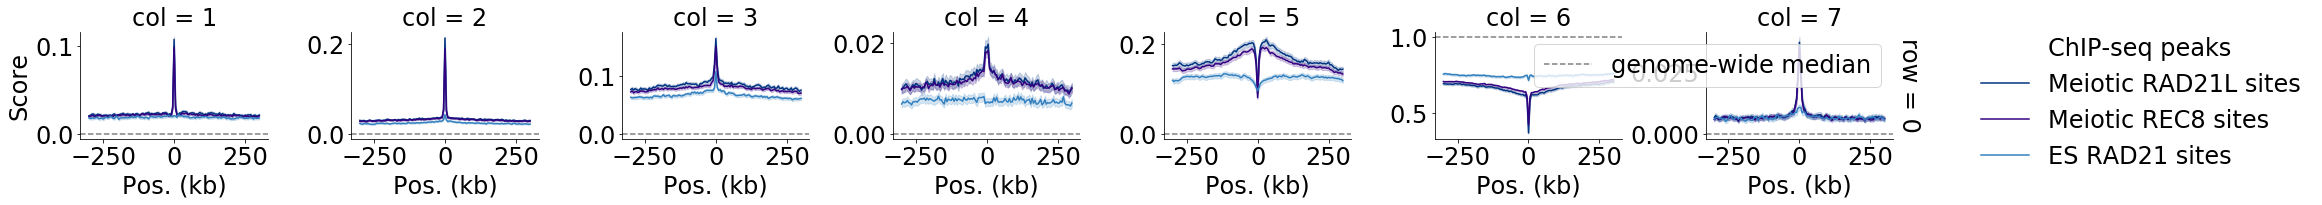

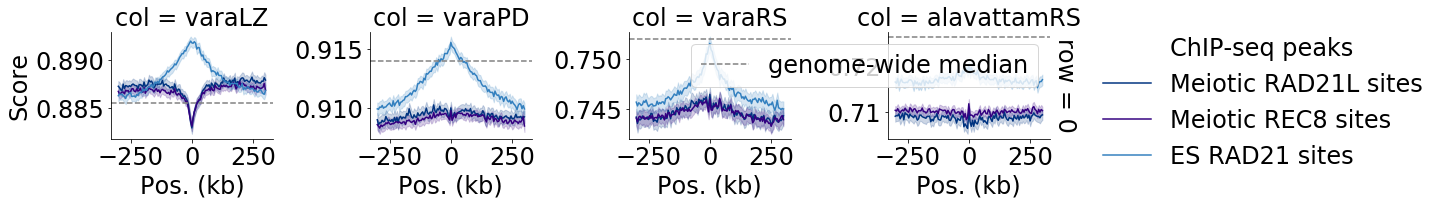

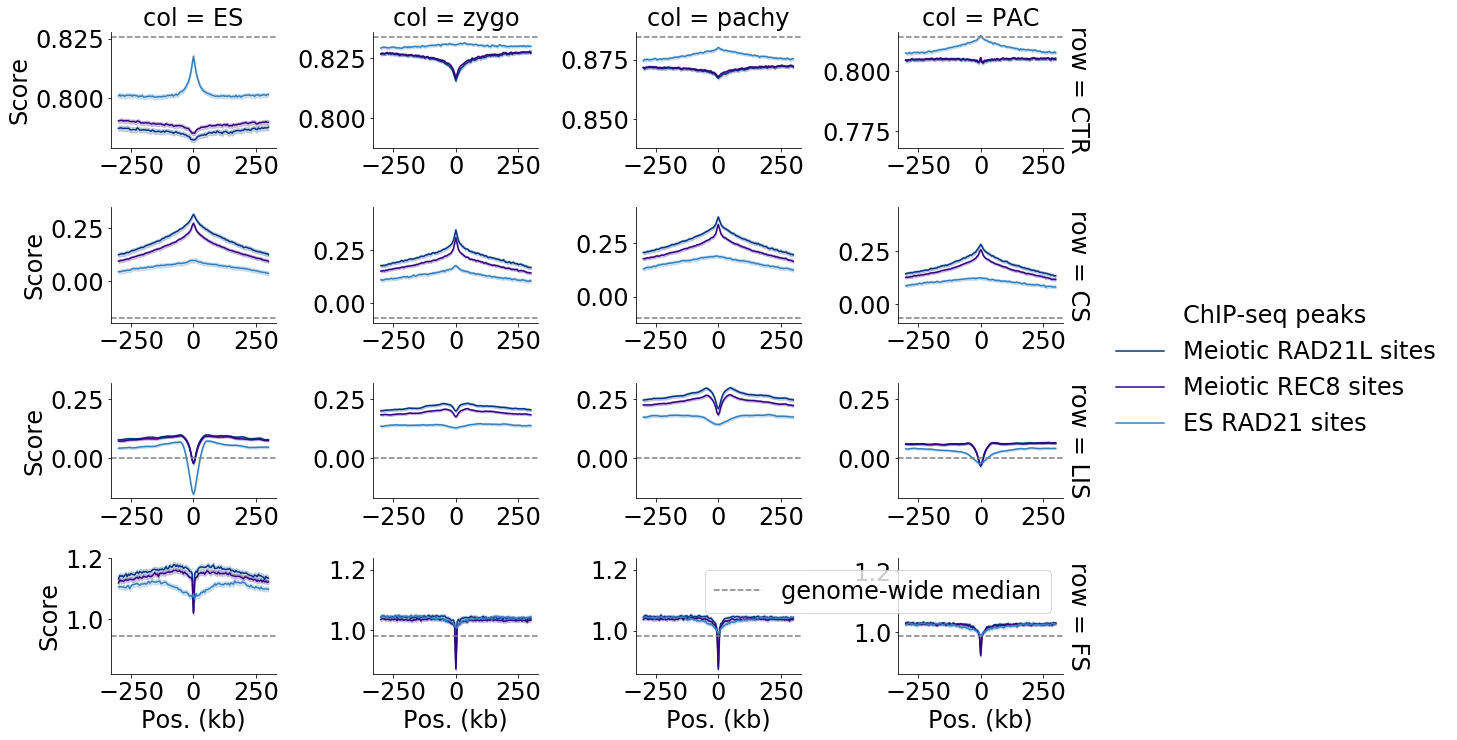

In [7]:
peakListMetaDict=cohesinPeakListMetaDict
for signalLabelDf in [chromHMMLabelsDf,extraCTRSignalLabelsDf,hicWangSignalLabelsDf]:
    if signalLabelDf.index.name=='extraCTR':
        shareColAxes='no'
    elif signalLabelDf.index.name=='chromhmm':
        shareColAxes='no'
        avgType='mean'
    else:
        shareColAxes='stretch'
    makeTracePlots(peakListMetaDict['dict'],signalLabelDf,
                       palette=peakListMetaDict['palette'],
                      saveName=f"{saveDir}/{peakListMetaDict['save']}_{signalLabelDf.index.name}_traceplots.pdf",
                       xlabel='Pos. (kb)',aspectRatio=1.5,shareColAxes=shareColAxes)

In [ ]:
for signalLabelDf in [lucasHapSignalLabelsDf,chromHMMLabelsDf,chipLabelsDf,tradHicSignalLabelsDf]:
    for peakListMetaDict in [prdm9splitCOPeakListMetaDict,prdm9PeakListMetaDict,DSBPeakListMetaDict,greyPrdm9castPeakListMetaDict,greyPrdm9b6PeakListMetaDict,greyPrdm9allPeakListMetaDict]:
        if signalLabelDf.index.name=='chromhmm':
            shareColAxes='no'
            avgType='mean'
        else:
            shareColAxes='stretch'
            avgType='median'            
        makeTracePlots(peakListMetaDict['dict'],signalLabelDf,
                       palette=peakListMetaDict['palette'],
                      saveName=f"{saveDir}/{peakListMetaDict['save']}_{signalLabelDf.index.name}_traceplots.pdf",
                       xlabel='Pos. (kb)',aspectRatio=1.5,
                      shareColAxes=shareColAxes,avgType=avgType)